In [138]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import tweepy as tp 
import pandas_datareader.data as web
import sklearn
import sklearn.linear_model 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### TO DO 
* ~~Get twitter data for the stock~~ (Canceled because of limited historic Tweets)
* ~~Get economic data~~
* ~~Create features~~
* ~~Create correlation graphs of features~~ 
* ~~Split Train and Test~~
* ~~turn them into functions - data_pull, data_prep, feature_plot, model_build, predict_model~~ 
* ~~Pick three methods (Linear Regression, Polynomial and Ridge.. Optional RNN )~~ 
* ~~Do some cool plots~~

### Run the cell below 

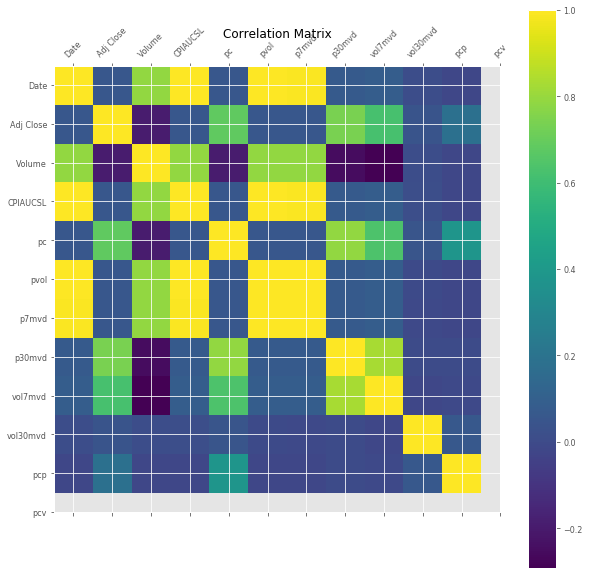

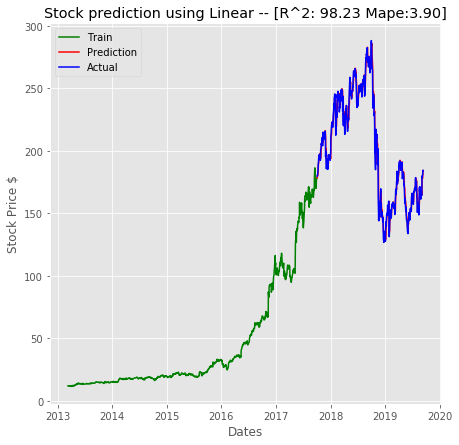

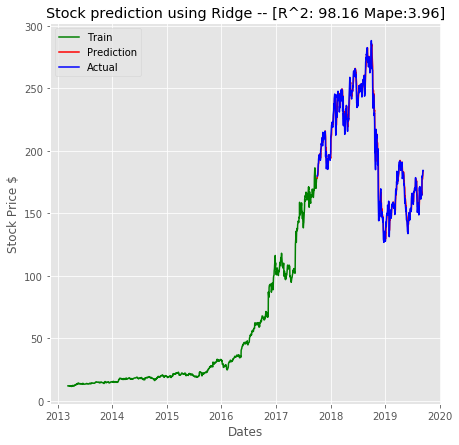

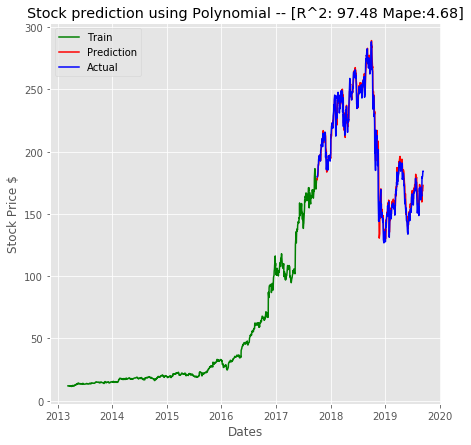

In [453]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(pd.datetime.now().date().year, pd.datetime.now().date().month,pd.datetime.now().date().day-1)
##Pull data from Yahoo and Fred
df = data_pull(start,end,'NVDA',econ_data=True)
df = feature_prep(df)
analyze_data(df)
rm_cols = ['Adj Close', 'Date']
X_train,Y_train, X_test,Y_test,msk = prep_data(df,rm_cols)

model_type = ['Linear','Ridge', 'Polynomial']
for model in model_type: 
    reg=build_model(X_train,Y_train,model)
    predict_plot(X_test,Y_test,df,msk,reg,model)
    

In [400]:
def data_pull(start,end,ticker,econ_data=True):
    stockdf = web.DataReader("NVDA", 'yahoo', start, end)
    freddf = web.DataReader(['CPIAUCSL'], 'fred', start, end)
    df = stockdf[['Adj Close','Volume']]
    df.reset_index(inplace=True)
    freddf.reset_index(inplace=True)
    #Merge on year and month since CPI is only monthly 
    if econ_data: 
        #CPI data is monthly so need to merget at a YY-MM level 
        df = pd.merge(df.assign(mkey=df['Date'].dt.to_period('M')),
                      freddf.assign(mkey=freddf['DATE'].dt.to_period('M')),
                      how='left',on='mkey')
        df = df.drop(['mkey','DATE'],axis=1)
        
    return df 

In [409]:
def feature_prep(df):
# Build the following features
# prior day close 
# prior day volume 
# 7 day moving average 
# 30 day moving average 
# CPI index 
# 7 day moving average vol 
# Percentage change from prior 
# Percentage change in volume
    df['pc'] = df['Adj Close'].shift(1)
    df['pvol'] = df['Volume'].shift(1)
    df['p7mvd'] = df['Adj Close'].rolling(window=7, min_periods=1).mean()
    df['p30mvd'] = df['Adj Close'].rolling(window=30,min_periods=1).mean()
    df['vol7mvd'] =  df['Volume'].rolling(window=7,min_periods=1).mean()
    df['vol30mvd'] =  df['Volume'].rolling(window=30,min_periods=1).mean()
    df['pcp'] = df['pc'].pct_change()
    df['pcv'] = df['pvol'].pct_change()
    df = df.fillna(df.iloc[:30].mean())
    return df 


In [431]:
#Plot Correlation Matrix with a Legend bar 
def analyze_data(df):
    style.use('ggplot')
    f = plt.figure(figsize=(10, 10))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=8, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=8)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=8)
    plt.title('Correlation Matrix', fontsize=12);

In [451]:
# Split train and test and convert to
def prep_data(df,rm_cols,split=.8):
    cols = [col for col in df.columns if col not in rm_cols ]
    np.random.seed(1)
    msk = int(split*len(df))
    X_train, Y_train = (df[cols]).iloc[:msk].to_numpy(),(df['Adj Close']).iloc[:msk].to_numpy()
    X_test, Y_test = df[cols][msk:len(df)].to_numpy(),df['Adj Close'][msk:len(df)].to_numpy()
    # Standardize x to mean 0 standardization 1 
    scaler = StandardScaler()
    X_train_trans = scaler.fit_transform(X_train)
    X_test_trans = scaler.transform(X_test)
    return X_train_trans,Y_train, X_test_trans,Y_test,msk



In [444]:
def build_model(X_train,Y_train,model_type): 

    if(model_type == 'Linear'): 
        reg = linear_model.LinearRegression()
        reg.fit(X_train, Y_train)

    elif (model_type == 'Ridge'): 
        reg = linear_model.Ridge(alpha=.5)
        reg.fit(X_train, Y_train)

    elif (model_type == 'Polynomial'): 
        reg = make_pipeline(PolynomialFeatures(2), Ridge())
        reg.fit(X_train, Y_train)

    return reg


In [449]:
def predict_plot(X_test,Y_test,df,msk,reg,model):
    ## Predict 
    y_pred = reg.predict(X_test)
    ## Plot the fits
    x_test = df[['Date']][msk:len(df)].to_numpy()
    x_train = df[['Date']][800:msk].to_numpy()
    f = plt.figure(figsize=(7, 7))

    plt.plot(x_train,Y_train[800:msk], 'g', label='Train')
    plt.plot(x_test,y_pred, 'r', label='Prediction')
    plt.plot(x_test,Y_test, 'b', label = 'Actual')
    plt.title("Stock prediction using %s -- [R^2: %.2f Mape:%.2f]"%(model,r2_score(Y_test, y_pred)*100,
                                                                 mean_absolute_error(Y_test, y_pred)))
    plt.xlabel('Dates')
    plt.ylabel('Stock Price $')
    plt.legend()
    plt.show()
